# Bounding box detection - Racoon data (Object Localization)


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

Please note that each image in the dataset has one racoon.

### Import the necessary libraries

In [0]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_path = '/content/drive/My Drive/R9'

In [5]:
#install rar
!apt-get install unrar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unrar is already the newest version (1:5.5.8-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [6]:
#create Dir
dirPath='/content/images'
!mkdir $dirPath

mkdir: cannot create directory ‘/content/images’: File exists


In [7]:
!m#unrara the images_racoon.rar
!unrar e /content/drive/My\ Drive/R9/images_racoon.rar $dirPath

/bin/bash: m#unrara: command not found

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/R9/images_racoon.rar


Would you like to replace the existing file /content/images/raccoon-1.jpg
 58076 bytes, modified on 2019-04-20 17:52
with a new one
 58076 bytes, modified on 2019-04-15 23:51

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


### Change directory

In [0]:
images = '/content/images'

### Load the training data from train.csv file

In [0]:
train_df = pd.read_csv(
    os.path.join(data_path, 'train_labels.csv')
)

In [10]:
print(train_df.head())

         filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298
4  raccoon-60.jpg    273     185  raccoon    58    33   197   127


In [0]:
imgpath = []
for img in train_df['filename']:
  img_path = os.path.join(images, img)
  imgpath.append(img_path)
train_df['filepath'] = imgpath

In [12]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,filepath
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118,/content/images/raccoon-17.jpg
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431,/content/images/raccoon-11.jpg
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290,/content/images/raccoon-63.jpg
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298,/content/images/raccoon-63.jpg
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127,/content/images/raccoon-60.jpg


### Print the shape of the train dataset

In [13]:
print(train_df.shape)

(173, 9)


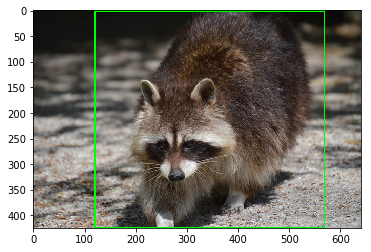

In [14]:
#Plot the image
#Pickup a random image number
img_num = np.random.randint(0, train_df.shape[0])

#Read the image and draw a rectangle as per bounding box information
img = cv2.imread(train_df.loc[img_num,'filepath'])
cv2.rectangle(img, 
             (train_df.loc[img_num, 'xmin'],train_df.loc[img_num, 'ymin']),
             (train_df.loc[img_num, 'xmax'],train_df.loc[img_num, 'ymax']), 
             (0,255,0),
             2)
#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.imshow(img)
plt.show()

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
img_size = 128

#### Build a Batch Generator

The batch generator should do the following:

1. Take batch_size and dataframe (build from csv file above) as input
2. Build random row indexes equal to batch size from the dataframe
3. Based on random indexes created above, read the dataframe to do following:
   - Read image and resize the image to 128x128
   - Convert it to numpy array
   - Read bounding box co-ordinates from dataframe for this image
   - Resize co-ordinates as we have resized the image
   - 'yield' batch of images and batch of co-ordinates
   
Please note that there is no classification task here as all images do have racoon's in them.

In [0]:
def batch_generator(df, batch_size=32):

    while True:

        #Create indexes
        image_nums = np.random.randint(0,df.shape[0], size=batch_size)

        #Create empty arrays
        #1. To hold image input
        batch_images = np.zeros(shape=(batch_size, img_size, img_size, 3))
        
        #Classification Labels 
#         batch_labels = np.zeros(shape=(batch_size, len(num_classes)))
        #Regression labels - 4 numbers per example image
  
        batch_bboxes = np.zeros(shape=(batch_size, 4))
        

        for i in range(batch_size):

            #Read image and resize
            img = tf.keras.preprocessing.image.load_img(df.loc[image_nums[i], 'filepath'], 
                                                        target_size=(img_size, img_size))
            
            #Conver to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            #Update batch
            batch_images[i] = img_array

           #Read image classification label & convert to one hot vector
#             cl_label = df.loc[image_nums[i], 'Label']
#             cl_label = tf.keras.utils.to_categorical(cl_label, num_classes=len(num_classes))
#             batch_labels[i] = cl_label

            #Read and resize bounding box co-ordinates
            img_width = df.loc[image_nums[i], 'width']
            img_height = df.loc[image_nums[i], 'height']
            
            xmin = df.loc[image_nums[i], 'xmin'] * img_size/img_width
            xmax = df.loc[image_nums[i], 'xmax'] * img_size/img_width

            ymin = df.loc[image_nums[i], 'ymin'] * img_size/img_height
            ymax = df.loc[image_nums[i], 'ymax'] * img_size/img_height

            #We will ask model to predict xmin, ymin, width and height of bounding box
            batch_bboxes[i] = [xmin, ymin, xmax-xmin, ymax-ymin]

        #Normalize batch images as per Pre-trained model to be used
        batch_images = tf.keras.applications.mobilenet.preprocess_input(batch_images)
        
        #Make bounding boxes (x, y, w, h) as numbers between 0 and 1 - this seems to work better
        batch_bboxes = batch_bboxes/img_size

        #Return batch - use yield function to make it a python generator
        #yield batch_images, [batch_labels, batch_bboxes]
        yield batch_images, [batch_bboxes]

In [0]:
#split into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_df, test_size=0.1)

In [0]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [63]:
print(train.head())
print(test.head())

   index         filename  width  ...  xmax ymax                         filepath
0    108   raccoon-61.jpg    274  ...   195  148   /content/images/raccoon-61.jpg
1    157  raccoon-136.jpg    256  ...   198  192  /content/images/raccoon-136.jpg
2    106  raccoon-119.jpg    400  ...   280  473  /content/images/raccoon-119.jpg
3      6  raccoon-180.jpg    600  ...   368  399  /content/images/raccoon-180.jpg
4    126   raccoon-32.jpg    625  ...   473  328   /content/images/raccoon-32.jpg

[5 rows x 10 columns]
   index         filename  width  ...  xmax ymax                         filepath
0    141  raccoon-173.jpg    550  ...   515  387  /content/images/raccoon-173.jpg
1     41   raccoon-47.jpg    262  ...   233  193   /content/images/raccoon-47.jpg
2     73   raccoon-75.jpg    640  ...   640  459   /content/images/raccoon-75.jpg
3     58  raccoon-131.jpg    259  ...   199  184  /content/images/raccoon-131.jpg
4     37  raccoon-123.jpg    640  ...   550  392  /content/images/raccoon-1

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
tf.keras.backend.clear_session()

#Do not include FC layer at the end
model = tf.keras.applications.mobilenet.MobileNet(include_top=False,
                                          input_shape=(img_size,img_size, 3),
                                          alpha=1)

In [65]:
len(model.layers)

87

In [0]:
for layer in model.layers:
    layer.trainable = False

In [0]:
x = model.layers[-1].output
x = tf.keras.layers.Conv2D(4, kernel_size=4, name='coords')(x)
x = tf.keras.layers.Reshape((4,))(x)

model = tf.keras.Model(inputs=model.input, outputs=[x])

### Define a custom metric function IoU which calculates Intersection Over Union

In [0]:
from keras.backend import epsilon
def calculate_iou(gt, pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(calculate_iou, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])

In [0]:
##Create train and test generator
batchsize = 32
train_generator = batch_generator(train, batch_size=batchsize)
test_generator = batch_generator(test, batch_size=batchsize)

In [73]:
test.shape[0], train.shape[0], train_df.shape[0]

(18, 155, 173)

In [76]:
model.fit_generator(train_generator, 
                          epochs=30,
                          steps_per_epoch= train.shape[0]//batchsize,
                          validation_data=test_generator,
                          validation_steps = 1)

Epoch 1/30
4/4 [==============================] - 7s 2s/step - loss: 18.0017 - IoU: 0.2799 - val_loss: 23.8486 - val_IoU: 0.0000e+00
Epoch 2/30
4/4 [==============================] - 6s 1s/step - loss: 11.6936 - IoU: 0.0318 - val_loss: 14.5648 - val_IoU: 0.0122
Epoch 3/30
4/4 [==============================] - 6s 1s/step - loss: 7.4094 - IoU: 0.1555 - val_loss: 7.1755 - val_IoU: 0.1259
Epoch 4/30
4/4 [==============================] - 6s 1s/step - loss: 6.2233 - IoU: 0.1705 - val_loss: 5.4132 - val_IoU: 0.0608
Epoch 5/30
4/4 [==============================] - 6s 1s/step - loss: 4.4043 - IoU: 0.0513 - val_loss: 4.1429 - val_IoU: 0.0394
Epoch 6/30
4/4 [==============================] - 6s 1s/step - loss: 3.2239 - IoU: 0.0993 - val_loss: 4.6255 - val_IoU: 0.1430
Epoch 7/30
4/4 [==============================] - 6s 1s/step - loss: 2.3178 - IoU: 0.0946 - val_loss: 7.7783 - val_IoU: 0.0343
Epoch 8/30
4/4 [==============================] - 6s 1s/step - loss: 2.6607 - IoU: 0.1302 - val_loss: 3

### Pick a test image from the given data

In [0]:
image_num = np.random.randint(0, train_df.shape[0])

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
region = []
w = ''
h = ''
img = ''
def predict_and_draw(image_num, df):
    global img
    #Load image
    img = tf.keras.preprocessing.image.load_img(df.loc[image_num, 'filepath'])
    global w
    global h
    w, h = img.size

    #Read actual label and bounding box
    #act_class = df.loc[image_num, 'Class']
    xmin, ymin, xmax, ymax = df.loc[image_num, ['xmin', 'ymin', 'xmax', 'ymax']]
    
    #Prepare input for model
    #1. Resize image
    img_resized = img.resize((img_size, img_size)) 
    #2. Conver to array and make it a batch of 1
    input_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    input_array = np.expand_dims(input_array, axis=0)
    #3. Normalize image data
    input_array = tf.keras.applications.mobilenet.preprocess_input(input_array)

    #Prediction
    pred = model.predict(input_array)
    #Get classification and regression predictions
    #label_pred, bbox_pred = pred[0][0], pred[0][0]
    bbox_pred = pred[0]
    
    global region
    region = bbox_pred

    #Get Label with highest probability
    #pred_class = label_class_dict[np.argmax(label_pred)]

    #print('Real Label :', act_class, '\nPredicted Label: ', pred_class)
    
    #Draw bounding boxes - Actual (Red) and Predicted(Green)
    img = cv2.imread(df.loc[image_num, 'filepath'])
    
#     #Draw actual bounding box
#     img = cv2.rectangle(img, (xmin, ymin), 
#                         (xmax, ymax), (0,0,255), 2)
    #Draw predicted bounding box
#     img = cv2.rectangle(img, (int(bbox_pred[0]*w), int(bbox_pred[1]*h)), 
#                         (int((bbox_pred[0]+bbox_pred[2])*w), int((bbox_pred[1]+bbox_pred[3])*h)), (0,255,0), 2)
    
    img = cv2.rectangle(img, (int(bbox_pred[0]*w), int(bbox_pred[1]*h)), 
                        (int((bbox_pred[0]+bbox_pred[2])*w), int((bbox_pred[1]+bbox_pred[3])*h)), (0,255,0), 2)
  
    #Display the picture
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

### Predict the coordinates of the bounding box for the given test image

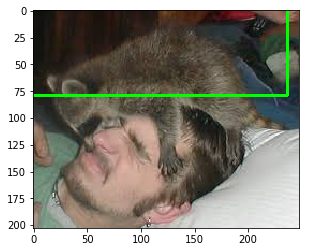

In [156]:
predict_and_draw(image_num, train_df)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

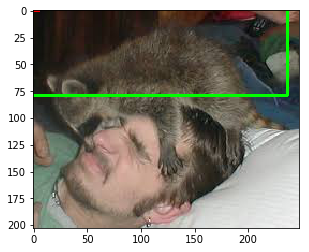

In [158]:
IMAGE_SIZE = img_size
image_width = w
image_height = h
unscaled = img

x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

In [0]:
# Import the necessary libraries

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

#### Mount google drive

In [177]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change your present working directory

In [0]:
dataFile = os.path.join(data_path, 'daily-minimum-temperatures-in-me.csv')

### Load your data file

In [0]:
df = pd.read_csv(dataFile, index_col='Date')

In [183]:
df.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


#### Plot data

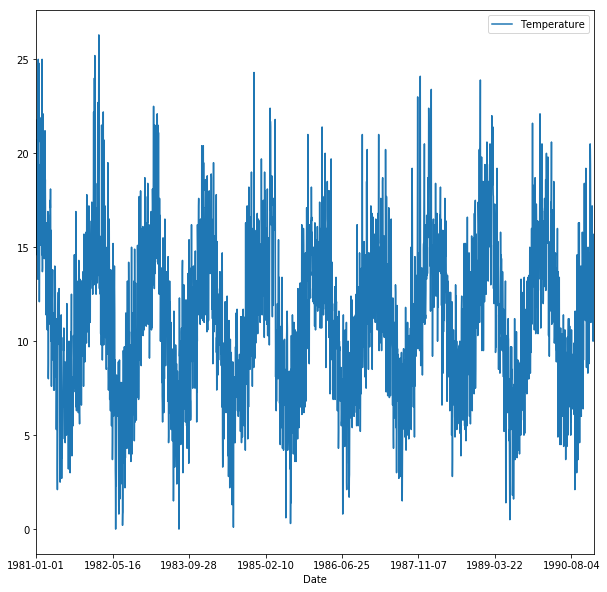

In [184]:
df.plot(figsize=(10,10))

#### Descibe your dataframe

In [185]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [186]:
df.isnull().sum()

Temperature    0
dtype: int64

In [187]:
print(df.isnull().any(axis=1).sum())

0


#### Drop null values

In [0]:

df.dropna(inplace=True)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84a88725f8>]],
      dtype=object)

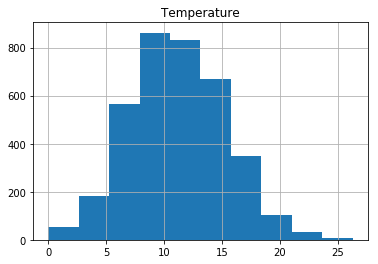

In [189]:
df.hist()

#### Check the maximum and minimum values

In [190]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

#### Check the maximum and minimum values of scaled data

In [192]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [193]:
print(scaled[:10])

[[0.78707224]
 [0.68060837]
 [0.7148289 ]
 [0.55513308]
 [0.60076046]
 [0.60076046]
 [0.60076046]
 [0.66159696]
 [0.82889734]
 [0.76045627]]


### Split data into Training and Testing

In [0]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [196]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [198]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.78707224]
Y 1
0.6806083650190113
1
X 1 to 2
[0.68060837]
Y 2
0.714828897338403
2
X 2 to 3
[0.7148289]
Y 3
0.5551330798479087
3
X 3 to 4
[0.55513308]
Y 4
0.6007604562737643
4
X 4 to 5
[0.60076046]
Y 5
0.6007604562737643
5
X 5 to 6
[0.60076046]
Y 6
0.6007604562737643
6
X 6 to 7
[0.60076046]
Y 7
0.6615969581749048
7
X 7 to 8
[0.66159696]
Y 8
0.8288973384030418
8
X 8 to 9
[0.82889734]
Y 9
0.7604562737642585
9
X 9 to 10
[0.76045627]
Y 10
0.6159695817490494
10
X 10 to 11
[0.61596958]
Y 11
0.5057034220532319
11
X 11 to 12
[0.50570342]
Y 12
0.6349809885931559
12
X 12 to 13
[0.63498099]
Y 13
0.8174904942965779
13
X 13 to 14
[0.81749049]
Y 14
0.9505703422053232
14
X 14 to 15
[0.95057034]
Y 15
0.7870722433460076
15
X 15 to 16
[0.78707224]
Y 16
0.7832699619771863
16
X 16 to 17
[0.78326996]
Y 17
0.9429657794676806
17
X 17 to 18
[0.94296578]
Y 18
0.6730038022813688
18
X 18 to 19
[0.6730038]
Y 19
0.5893536121673003
19
X 19 to 20
[0.58935361]
Y 20
0.6920152091254752
20
X 20 to 21


#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [199]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
batch_size = 1 

model = Sequential()

model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Summarize your model

In [205]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_4 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [206]:
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
 - 5s - loss: 0.0305
Epoch 2/100
 - 4s - loss: 0.0175
Epoch 3/100
 - 4s - loss: 0.0147
Epoch 4/100
 - 4s - loss: 0.0122
Epoch 5/100
 - 4s - loss: 0.0116
Epoch 6/100
 - 4s - loss: 0.0111
Epoch 7/100
 - 4s - loss: 0.0107
Epoch 8/100
 - 4s - loss: 0.0107
Epoch 9/100
 - 4s - loss: 0.0105
Epoch 10/100
 - 4s - loss: 0.0104
Epoch 11/100
 - 4s - loss: 0.0104
Epoch 12/100
 - 4s - loss: 0.0103
Epoch 13/100
 - 4s - loss: 0.0103
Epoch 14/100
 - 4s - loss: 0.0103
Epoch 15/100
 - 4s - loss: 0.0102
Epoch 16/100
 - 4s - loss: 0.0102
Epoch 17/100
 - 4s - loss: 0.0102
Epoch 18/100
 - 4s - loss: 0.0102
Epoch 19/100
 - 4s - loss: 0.0102
Epoch 20/100
 - 4s - loss: 0.0102
Epoch 21/100
 - 4s - loss: 0.0102
Epoch 22/100
 - 4s - loss: 0.0101
Epoch 23/100
 - 4s - loss: 0.0102
Epoch 24/100
 - 4s - loss: 0.0101
Epoch 25/100
 - 4s - loss: 0.0102
Epoch 26/100
 - 4s - loss: 0.0101
Epoch 27/100
 - 4s - loss: 0.0101
Epoch 28/100
 - 4s - loss: 0.0101
Epoch 29/100
 - 4s - loss: 0.0101
Epoch 30/100
 - 4s - lo

## Make Predictions and Evaluate your model

In [0]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

In [0]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [210]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.48 RMSE


## Plot the results

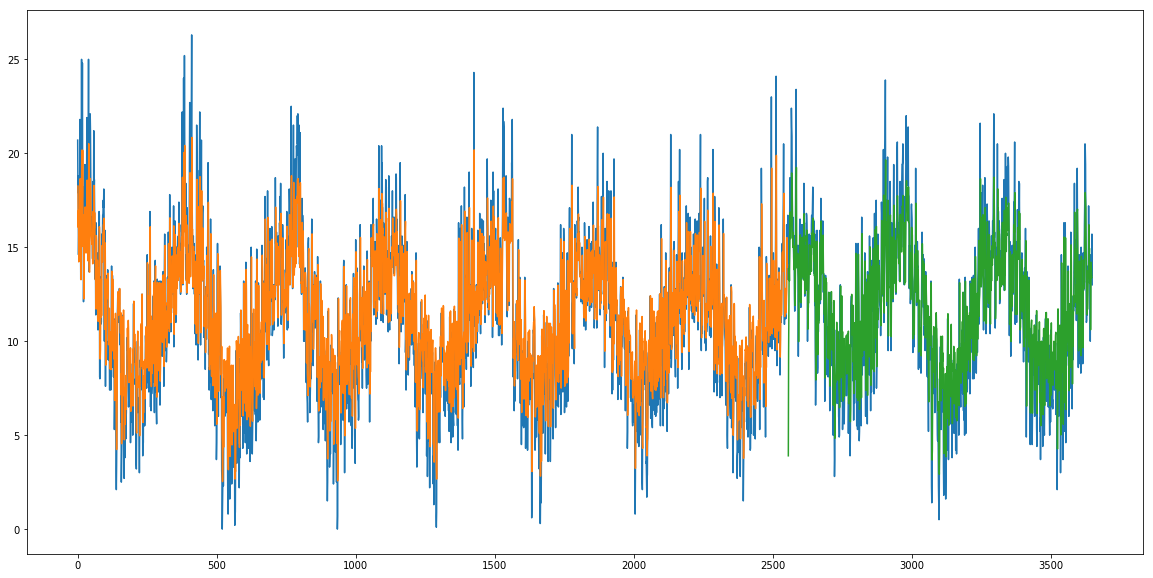

In [211]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()